In [1]:
from tensorflow.keras.applications import VGG16
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from tensorflow.keras import optimizers

In [2]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

58900480/58889256 [==============================] - 5s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [4]:
%whos

Variable             Type          Data/Info
--------------------------------------------
ImageDataGenerator   type          <class 'keras.preprocessi<...>mage.ImageDataGenerator'>
VGG16                function      <function VGG16 at 0x7f3c6ecd5ca0>
autopep8             module        <module 'autopep8' from '<...>te-packages/autopep8.py'>
conv_base            Functional    <keras.engine.functional.<...>object at 0x7f3c6c357fa0>
json                 module        <module 'json' from '/usr<...>hon3.8/json/__init__.py'>
layers               module        <module 'keras.layers' fr<...>eras/layers/__init__.py'>
models               module        <module 'keras.models' fr<...>ackages/keras/models.py'>
np                   module        <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
optimizers           module        <module 'keras.api._v2.ke<...>/optimizers/__init__.py'>
os                   module        <module 'os' from '/usr/lib/python3.8/os.py'>


In [5]:
original_dataset_dir='./dogs-vs-cats/train'

base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape= (sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size>=sample_count:
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir,2000)
validation_features, validation_labels = extract_features(validation_dir,1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_features = np.reshape(train_features, (2000,4*4*512))
validation_features = np.reshape(validation_features, (1000,4*4*512))
test_features = np.reshape(test_features, (1000,4*4*512))

In [9]:
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 10ms/step - loss: 0.6292 - acc: 0.6515 - val_loss: 0.4374 - val_acc: 0.8470
Epoch 2/30
100/100 [==============================] - 1s 9ms/step - loss: 0.4304 - acc: 0.8085 - val_loss: 0.3491 - val_acc: 0.8800
Epoch 3/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3559 - acc: 0.8435 - val_loss: 0.3145 - val_acc: 0.8780
Epoch 4/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3051 - acc: 0.8800 - val_loss: 0.3150 - val_acc: 0.8650
Epoch 5/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2861 - acc: 0.8835 - val_loss: 0.2765 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2544 - acc: 0.9005 - val_loss: 0.2719 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2406 - acc: 0.9095 - val_loss: 0.2581 - val_acc: 0.9040
Epoch 8/30
100/100 [==============================] - 1s 9ms/step - loss: 0

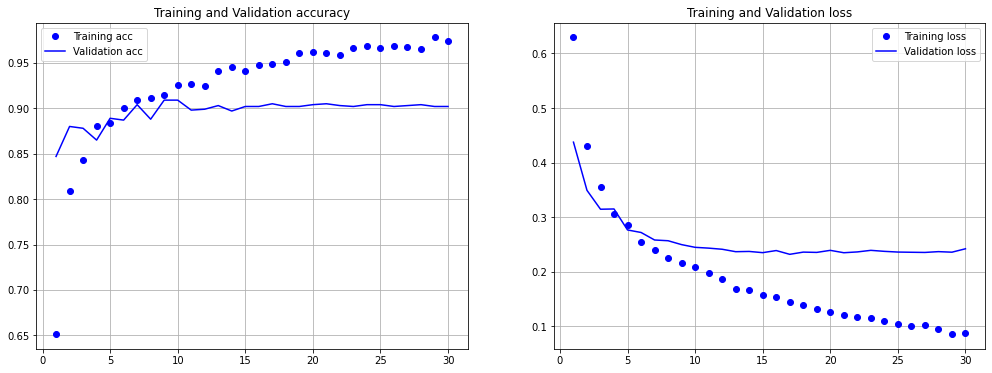

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(17,6))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.grid()
plt.legend()

/usr/bin/sh: 1: jt: not found


/usr/bin/sh: 1: jt: not found
